# Training

In [1]:
# some how we need to use this import block code, because of some reason that will not allow us to import other module in this file.
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

##### Import Library

In [2]:
import pandas as pd
import numpy as np
from ModelDevelopment.CustomPipeline import CustomPipeline

Import the Classifiers

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

Import Metrics that we need to use

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

##### Load the dataset

In [5]:
df = pd.read_csv('../Dataset/datasets.csv')
# Split the sentence and label into single variable.
X = df['sentence']
y = df['label']

we need to define some config of each classifier (Form the experiment)

These configs will contain:
* classifier
* and hyperparameters

In [6]:
configs = [
    {'classifier': LogisticRegression(random_state=100), 'hyperparameters': {'classifier__C': 0.1}},
    {'classifier': LogisticRegression(random_state=100), 'hyperparameters': {'classifier__C': 1}},
    {'classifier': LogisticRegression(random_state=100), 'hyperparameters': {'classifier__C': 1.6}},
    
    {'classifier': MultinomialNB(), 'hyperparameters': {'classifier__alpha': 0.1}},
    {'classifier': MultinomialNB(), 'hyperparameters': {'classifier__alpha': 0.5}},
    {'classifier': MultinomialNB(), 'hyperparameters': {'classifier__alpha': 0.9}},
    
    {'classifier': RandomForestClassifier(random_state=100), 'hyperparameters': {'classifier__n_estimators': 100}},
    {'classifier': RandomForestClassifier(random_state=100), 'hyperparameters': {'classifier__n_estimators': 200}},
    {'classifier': RandomForestClassifier(random_state=100), 'hyperparameters': {'classifier__n_estimators': 250}},
    
    {'classifier': XGBClassifier(), 'hyperparameters': {'classifier__n_estimators': 100}},
    {'classifier': XGBClassifier(), 'hyperparameters': {'classifier__n_estimators': 200}},
    {'classifier': XGBClassifier(), 'hyperparameters': {'classifier__n_estimators': 250}},
    
    {'classifier': MLPClassifier(max_iter=1000, random_state=100), 'hyperparameters': {'classifier__hidden_layer_sizes': (100,)}},
    {'classifier': MLPClassifier(max_iter=1000, random_state=100), 'hyperparameters': {'classifier__hidden_layer_sizes': (10, 10)}},
    {'classifier': MLPClassifier(max_iter=1000, random_state=100), 'hyperparameters': {'classifier__hidden_layer_sizes': (20, 20)}},
]

In [7]:
# Instantiate the 5-fold the do the cross valiation.
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
all_hist = []
fold_hist = []
best_score = -np.inf
best_classifier_type = {}
best_classifier_hist = None

for config in configs:
    classifier = config['classifier']
    classifier_type = type(classifier).__name__
    hyperparameters = config['hyperparameters']
    
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'precision(-)': [],
        'recall(-)': [],
        'f1(-)': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Instantiate CustomPipeline with just the classifier
        pipeline = CustomPipeline(classifier)
        
        # Set hyperparameters
        pipeline.set_params(**hyperparameters)
        
        # Fit the pipeline
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_val)
        
        fold_result = {
            'fold': fold+1,
            'config': config,
            'accuracy': accuracy_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred),
            'f1': f1_score(y_val, y_pred),
            'precision(-)': precision_score(y_val, y_pred, pos_label=1, zero_division=1),
            'recall(-)': recall_score(y_val, y_pred, pos_label=1, zero_division=1),
            'f1(-)': f1_score(y_val, y_pred, pos_label=1, zero_division=1)
        }
        
        fold_hist.append(fold_result)
        
        fold_metrics['accuracy'].append(fold_result['accuracy'])
        fold_metrics['precision'].append(fold_result['precision'])
        fold_metrics['recall'].append(fold_result['recall'])
        fold_metrics['f1'].append(fold_result['f1'])
        fold_metrics['precision(-)'].append(fold_result['precision(-)'])
        fold_metrics['recall(-)'].append(fold_result['recall(-)'])
        fold_metrics['f1(-)'].append(fold_result['f1(-)'])
        
    avg_metrics = {metric: np.mean(scores) for metric, scores in fold_metrics.items()}
    avg_metrics['config'] = config
    all_hist.append(avg_metrics)
    
    if avg_metrics['accuracy'] > best_score:
        best_score = avg_metrics['accuracy']
        best_classifier_hist = avg_metrics
    if classifier_type not in best_classifier_type or avg_metrics['accuracy'] > best_classifier_type[classifier_type]['accuracy']:
        best_classifier_type[classifier_type] = avg_metrics


In [8]:
import matplotlib.pyplot as plt

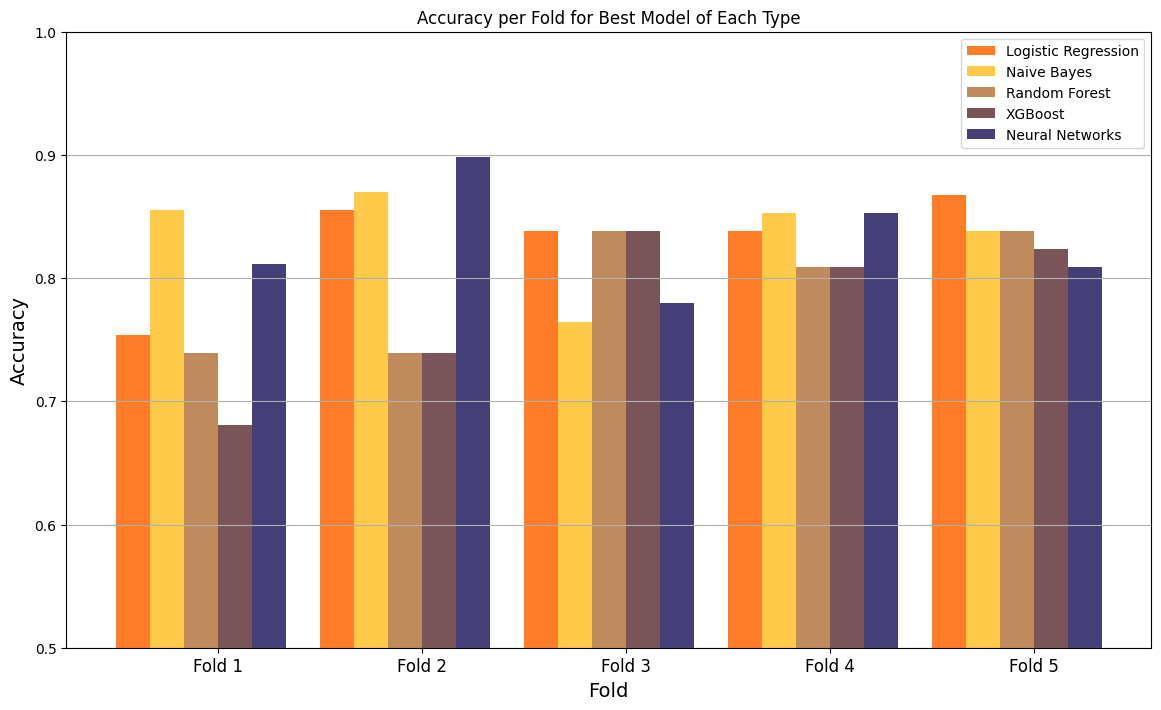

In [9]:
n_folds = max([fold['fold'] for fold in fold_hist])
model_types = list(best_classifier_type.keys())
n_model_types = len(model_types)
    
# Mapping model names
model_name_mapping = {
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Naive Bayes',
    'RandomForestClassifier': 'Random Forest',
    'XGBClassifier': 'XGBoost',
    'MLPClassifier': 'Neural Networks'
}
    
# Prepare data
accuracies_per_fold = {model_type: [] for model_type in model_types}
for model_type, best_model in best_classifier_type.items():
    accuracies = [fold['accuracy'] for fold in fold_hist if fold['config'] == best_model['config']]
    accuracies_per_fold[model_type] = accuracies
    
bar_width = 0.15
index = np.arange(n_folds) * (n_model_types + 1) * bar_width  # Add spacing between folds
colors = ['#FF7D29', '#FFC94A', '#C08B5C', '#795458', '#453F78']
    
plt.figure(figsize=(14, 8))
    
for i, (model_type, color) in enumerate(zip(model_types, colors)):
    accuracies = accuracies_per_fold[model_type]
    display_name = model_name_mapping.get(model_type, model_type)  # Use mapping or default to model_type
    plt.bar(index + i * bar_width, accuracies, bar_width, label=display_name, color=color)
    
plt.xlabel('Fold', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy per Fold for Best Model of Each Type')
plt.xticks(index + bar_width * (n_model_types / 2), ['Fold ' + str(i + 1) for i in range(n_folds)], fontsize=12)  # Increase font size
plt.ylim(0.5, 1)  # Set the y-axis limit to start at 0.5
plt.legend()
plt.grid(True, axis='y')
plt.show()

In [10]:
best_classifier_hist

{'accuracy': 0.8361040068201193,
 'precision': 0.8391408185807684,
 'recall': 0.8892397660818713,
 'f1': 0.8602764712540413,
 'precision(-)': 0.8391408185807684,
 'recall(-)': 0.8892397660818713,
 'f1(-)': 0.8602764712540413,
 'config': {'classifier': MultinomialNB(alpha=0.5),
  'hyperparameters': {'classifier__alpha': 0.5}}}

From the results we get the Naive Bayes classifier for the best of training,

Now we need to make it into the Pickle file for easy to move over other file and easy to use in Evaluate file.

In [11]:
# Get the best hyperparameters for the Naive Bayes.
nb_parameters = best_classifier_hist['config']['hyperparameters']
nb_parameters

{'classifier__alpha': 0.5}

In [12]:
import pickle

In [13]:
naive_bayes_classifier = CustomPipeline(MultinomialNB())
naive_bayes_classifier.set_params(**nb_parameters)
naive_bayes_classifier.fit(X, y)

Pipeline(steps=[('tokenizer', Tokenizer()), ('vectorizer', Vectorizer()),
                ('classifier', MultinomialNB(alpha=0.5))])

In [14]:
with open('Naive Bayes_pipeline.pickle', 'wb') as f:
    pickle.dump(naive_bayes_classifier, f)